In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.functions import col,isnan,when,count
import pandas as pd
from IPython.display import Image, display
from functools import reduce

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/14 13:48:29 WARN Utils: Your hostname, Zhangs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.12.6.181 instead (on interface en0)
22/10/14 13:48:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/14 13:48:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/14 13:48:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/14 13:48:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/14 13:48:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
# read all the dataframe
transaction = spark.read.parquet('../data/curated/final_transaction.parquet')
merchants = spark.read.parquet('../data/curated/final_merchant.parquet')
census = spark.read.parquet('../data/curated/final_census.parquet')
final = spark.read.parquet('../data/curated/merchant_info.parquet')

pure_add_rank = pd.read_parquet('../data/curated/baseline.parquet')
sorted_self_weight_score = pd.read_parquet('../data/curated/self_weight.parquet')
entropy_score = pd.read_parquet('../data/curated/entropy_weight.parquet')
sum_rank = pd.read_parquet('../data/curated/sum_rank.parquet')
study_score = pd.read_parquet('../data/curated/study_score_rank.parquet')
top_100 = pd.read_parquet('../data/curated/top_100.parquet')
art_combine = pd.read_parquet('../data/curated/art_combine.parquet')
sports_combine = pd.read_parquet('../data/curated/sports_combine.parquet')
technology_combine = pd.read_parquet('../data/curated/technology_combine.parquet')
home_combine = pd.read_parquet('../data/curated/home_combine.parquet')
health_combine = pd.read_parquet('../data/curated/health_combine.parquet')
compare_feature_rank = pd.read_parquet('../data/curated/compare_feature_rank.parquet')
tbl_merchants = spark.read.parquet('../data/tables/tbl_merchants.parquet')

 


# Summary Notebook

## 1. Pre-processing of the provided raw dataset as well as the found external data

### 1.1 Provided dataset
#### 1.1.1 For transaction data:  

a. Combine all the original transaction table into one dataframe, total num of rows bsfore null value check is 14195505.  
  
i) First check all the data for null values, and no null values are found.  
ii) For order datetime check whether in the range from 2021-02-28 to 2022-08-28, 1634128 rows of data are deleted. Num of rows after date check is 12561377.  
iii) Check all transaction amounts (<font color = #deab8a>'dollar_value'</font>) for each company for outliers,and delete outliers for each company. Total 1502453 rows are deleted. Num of rows after delete outlier is 11058924.  

b. Create a new feature for whether it is a large order (artificially set the transaction with a dollar value greater than 10,000 as a large order. If it is a large order, mark it as 1, if not, mark it as 0).  


#### 1.1.2 For fraud data:  

a. Check the null value and whether in the range from 2021-02-28 to 2022-08-28, no data is deleted, total 34864 rows.  
b. Create a new feature for whether it is fraud (artificially set the fraud probability as larger than 70%  If it is larger than 70%, assumed fraud mark it as 1, if not, mark it as 0).

In [3]:
transaction.limit(3)

user_id,merchant_abn,dollar_value,order_datetime,whether_bigorder,postcode,average_prob_con,whether_fraud
4748,24406529929,90.0893800907789,2022-05-22,0,3373,10.256077060613642,0
4748,73841664453,20.57693546236876,2021-08-08,0,3373,10.256077060613642,0
4748,83412691377,41.21691457183529,2022-03-07,0,3373,10.256077060613642,0


#### 1.1.3 For merchant data:  

Total 4422 merchants.  
Separate the tag into 3 features: 'Store_type', 'Revenue_levels', 'Take_rate'


In [4]:
merchants.limit(3)

merchant_abn,Store_type,Revenue_levels,Take_rate
10023283211,"furniture, home f...",e,0.18
10142254217,"cable, satellite,...",b,4.22
10165489824,"jewelry, watch, c...",b,4.40


### 1.2 External dataset
#### 1.2.1 For census data:  

Select age and income tables. In each SA2 region,  
a. calculate the proportion of the age group between 20-64 in total number of people in that region (Assume this age group has a higher level of consumption).  
b. calculate the proportion of people earning above the Australian weekly median income ($1200) to the total number of people (Assume the higher the proportion in this area, the higher the level of consumption).


In [5]:
census.limit(3)

SA2_CODE_2021,income_percentage,age_percentage
103021063,0.16390423572744015,0.49908336029332473
103021064,0.17449106771915246,0.5138208537438769
118021654,0.39097577239386533,0.5578328283728391


## 2. Combine table

### 2.1 Combine transaction information into merchant  

a. Obtain the average monthly order amount(<font color = #deab8a>'Avg_amount_monthly'</font>), count(<font color = #deab8a>'Avg_count_monthly'</font>), and amount per order for each company('Order_avg_value') and the number of large orders(<font color = #deab8a>'count_of_bigorder'</font>).  
b. Estimate the monthly amount BNPL can earn if they work with the merchant by average monthly order amount times take rate(<font color = #deab8a>'Take_rate'</font>).    
c. Obtain the average number of different customers per month for each merchant(<font color = #deab8a>'count_cus_per_mon'</font>), the average probability of fraud for all customers(<font color = #deab8a>'avg_prob_fraud_cus'</font>), and the percentage of those customers who are fraudulent out of the total number of customers(<font color = #deab8a>'prob_num_of_fraud'</font>).  
d. Find the number of people who came more than or equal to 5 times in 18 months as regular customers(<font color = #deab8a>'fix_cus_num'</font>).    

### 2.2 Combine census information into merchant 

a. Take the most common postcode of all customers of each merchant, and then guess that this postcode is the merchant's postcode(<font color = #deab8a>'postcode'</font>).     
b. After converting SA2 of census data into postcode, merging them with the estimated merchant postcode to obtain the census information for each merchant's location(<font color = #deab8a>'avg_income_percentage', 'avg_age_percentage'</font>).

In [6]:
final.limit(3)

Store_type,Revenue_levels,Take_rate,count_of_bigorder,Avg_amount_monthly,Avg_count_monthly,Order_avg_value,postcode,avg_prob_fraud_cus,prob_of_fraud,count_cus_per_mon,merchant_abn,fix_cus_num,avg_income_percentage,avg_age_percentage,predict_dollar_value
shoe shops,b,5088.108,0,1169.68,3.28,356.85,1660,16.41769282602561,0.0,3.28,42330360779,0,0.3924226684563543,0.5395286144327325,391.16650390625
"opticians, optica...",a,8020.69,0,1289.5,21.56,59.82,1660,15.594208059208613,0.0,21.28,73221370757,0,0.3924226684563543,0.5395286144327325,115.49871063232422
art dealers and g...,c,5908.3479,0,3126.11,2.44,1278.86,2482,14.965341864244008,0.0,2.44,97598804219,0,0.19071467244179752,0.5701438848920863,927.2828369140625


## 3. Visualization

### 3.1 Visualization

##### The distribution of the average value of each order

The companies with value of order below 134 are the most numerous. The image becomes a continuous downward trend, as the higher the amount the smaller the number of merchants that fit the range. This is also consistent with common sense, as small orders tend to be more prevalent than large orders.

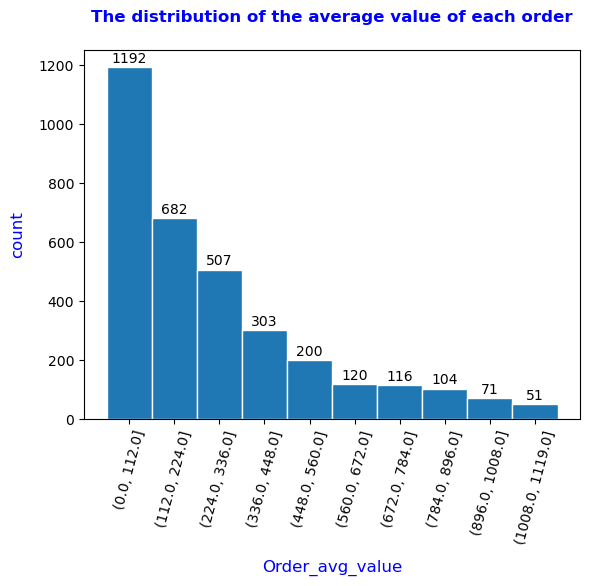

In [7]:
listOfImageNames = ['../plots/avg_value_per_order.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of average number of different consumer per month per shop

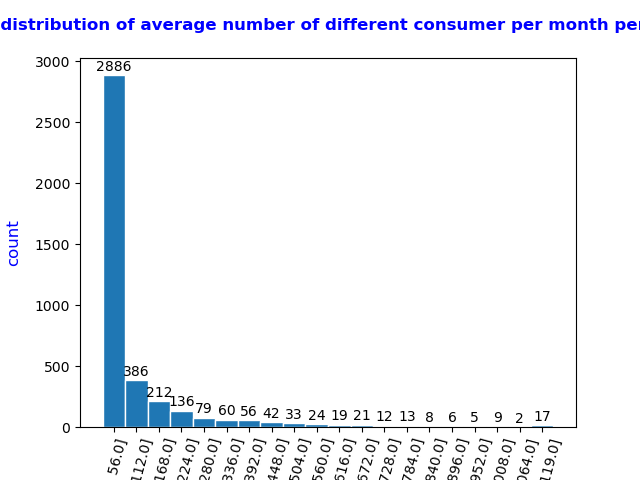

In [8]:
listOfImageNames = ['../plots/num_of_customer_per_month.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of the average amount of the transaction in each month

In order to better observe the distribution of count data in the table, we distinguish the table according to the size of the count. amount larger than 1400 is the table of large amount, and on the contrary, amount smaller than 1400 is the table of small amount.

For the data tables with counts less than 1400, we can find that the number of eligible companies decreases gradually as the average value increases in the first interval of most of the data sets. The average trading count of most companies is between 0 and 47. For data with counts greater than 1400, we decided to study the distribution of company tags in these data. tent has a significantly higher number of average counts than other companies.


small

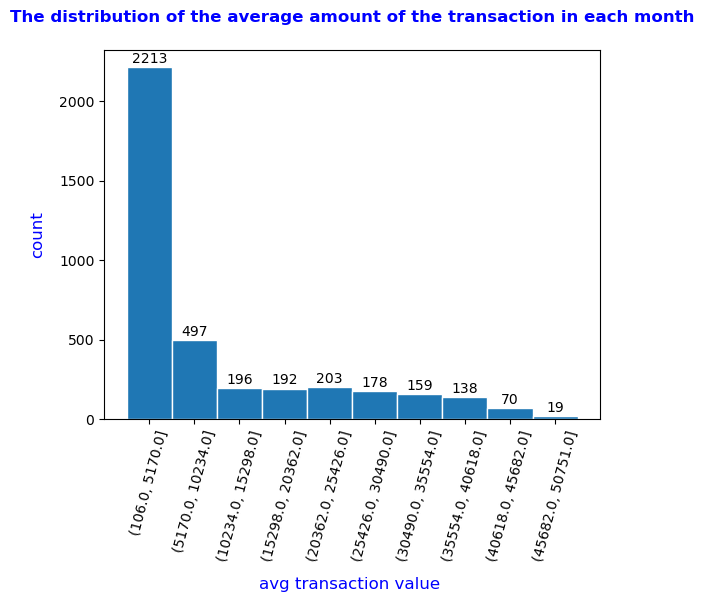

In [9]:
listOfImageNames = ['../plots/avg_amount_count_small.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


large

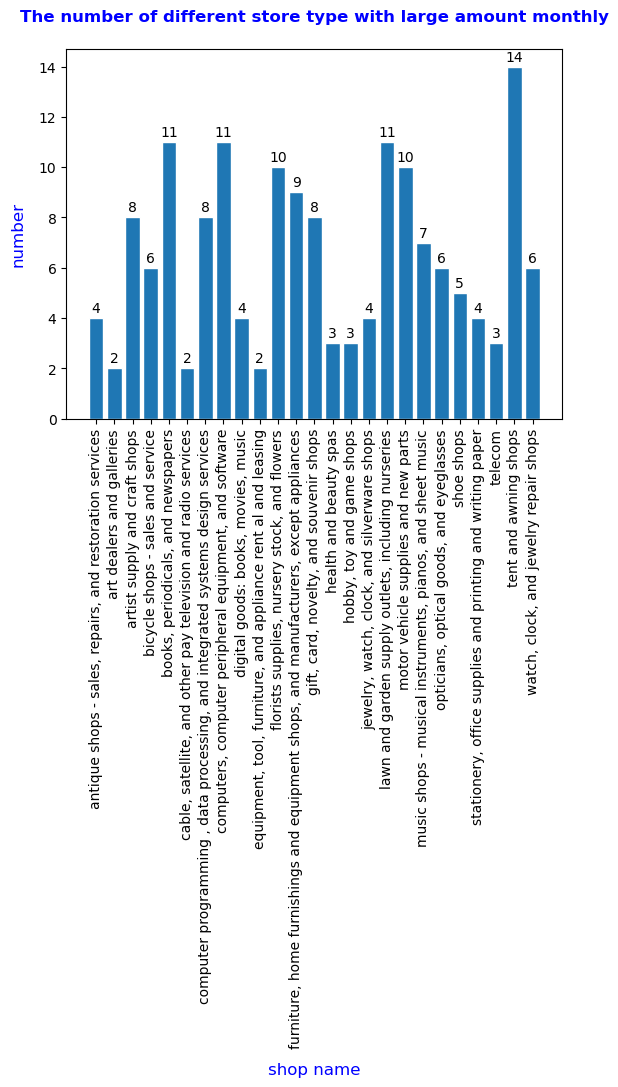

In [10]:
listOfImageNames = ['../plots/store_type_large_amount.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The distribution of the average count of the transaction in each month

In order to better observe the data distribution of the amounts in the tables, we distinguished the tables according to the size of the amout. amounts greater than 51,000 were the large amount tables, and on the contrary, amounts less than 51,000 were the small amounts tables.

For the data table with amout less than 51000, we can find that most of the data are concentrated in the first interval, and some in the second interval. The number of companies in the rest of the interval is about the same. The number of companies with large transactions is less. By analyzing the distribution of tags in the large amount data, we can find that the number of large transactions in books and IT companies is the most, and these companies have better development prospects compared to other companies and earn more money.

small

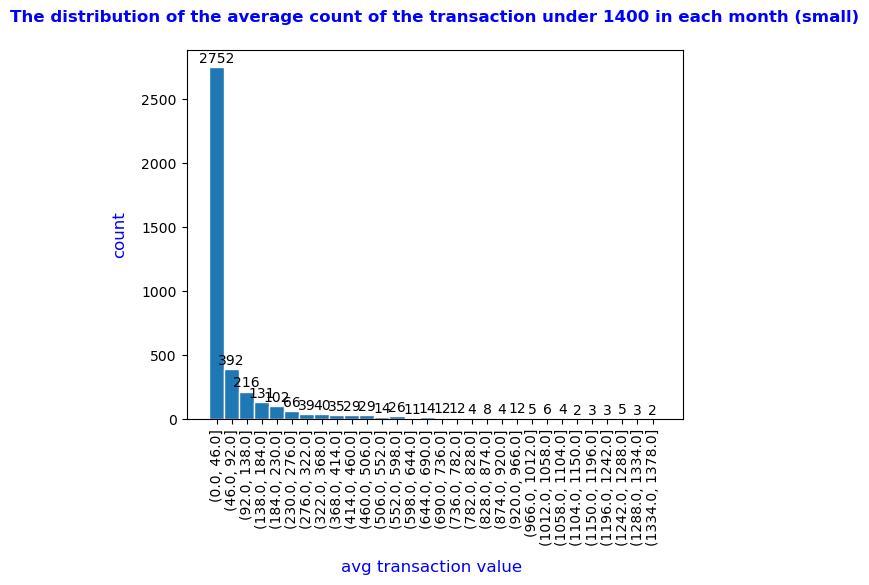

In [11]:
listOfImageNames = ['../plots/Avg_count_monthly_small.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


large

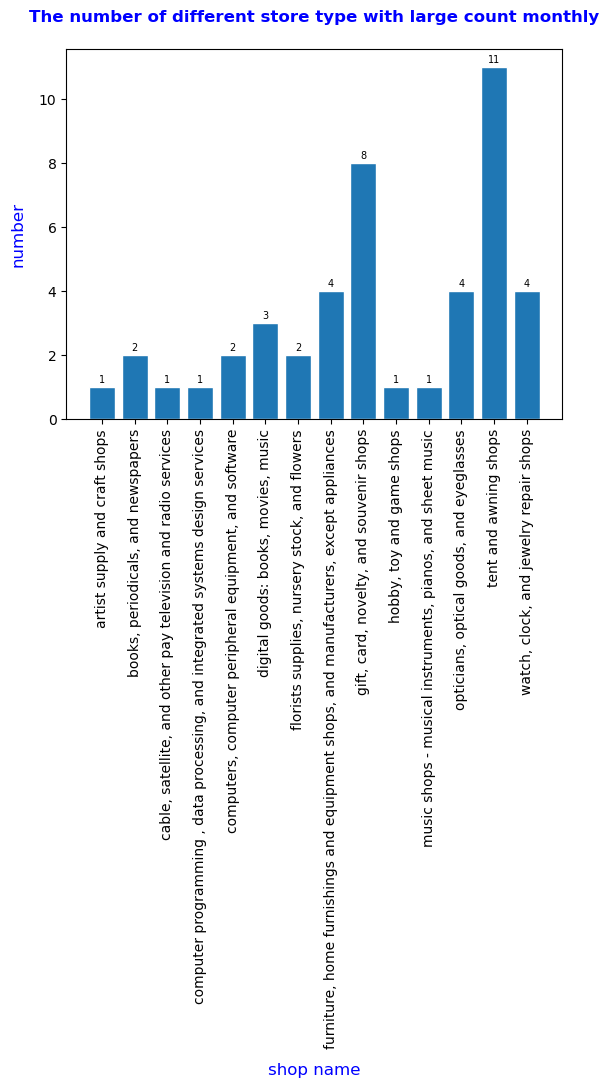

In [12]:
listOfImageNames = ['../plots/store_type_large_count.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


##### The number of different store type

According to the statistics of each merchant's tag, we can find that the number of merchants for digital goods is the largest, followed by the number of watch industry is the smallest. The number of merchants with more than 190 has three types of tags: IT companies, artist supply, and digital goods, which are the three most popular types of merchants among Australians.

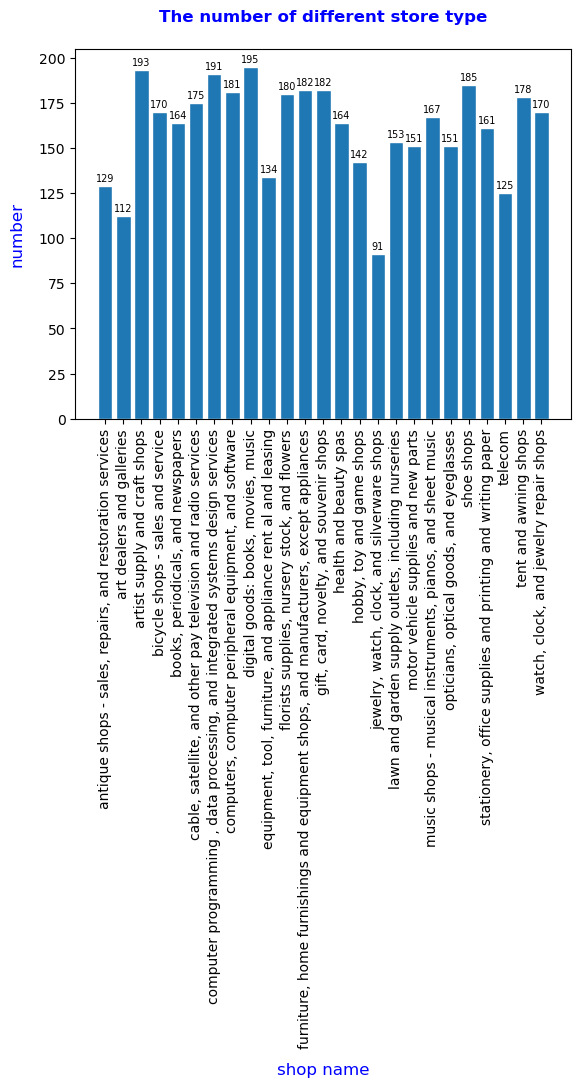

In [13]:
listOfImageNames = ['../plots/store_type.png']
for imageName in listOfImageNames:
    display(Image(filename= imageName))


### 3.2 Geovisualization

According to the postcode, draw the proportion of the age group between 20-64 in total number of people in that region and the proportion of people earning above the Australian weekly median income ($1200) to the total number of people. The darker the color on the geo graph, the higher the percentage and the higher the consumption level of the people in the region.

## 4. Model

### 4.1 Model Based on Scores  

a. Two ways to do mapping to put all data in the same scale:     
i) Z-score: <font color = #deab8a>New value = (x – μ) / σ</font>       
where x: Original value, μ: Mean of data, σ: Standard deviation of data   

ii) min_max (0-100): <font color = #deab8a>zi = (xi – min(x)) / (max(x) – min(x)) * 100</font>    
where zi: The ith normalized value in the dataset, xi: The ith value in the dataset, min(x): The minimum value in the dataset, max(x): The maximum value in the dataset

b. After mapping, three ways to calculate the final score based on min_max(0-100)    
i) Direct summation as baseline     

In [38]:
pure_add_rank[['merchant_abn','Store_type','pure_add_score']].head(10)

,merchant_abn,Store_type,pure_add_score
0,24852446429,"florists supplies, nursery stock, and flowers",558.304777
1,64203420245,tent and awning shops,556.441683
2,49891706470,tent and awning shops,530.690922
3,86578477987,"watch, clock, and jewelry repair shops",521.212252
4,43186523025,"florists supplies, nursery stock, and flowers",486.137014
5,89726005175,tent and awning shops,486.090310
6,64403598239,"music shops - musical instruments, pianos, and...",468.177753
7,46804135891,"opticians, optical goods, and eyeglasses",467.686976
8,45629217853,"gift, card, novelty, and souvenir shops",465.653554
9,60956456424,"gift, card, novelty, and souvenir shops",451.144286


ii) Weighting: subjective weighting    

In [39]:
sorted_self_weight_score[['merchant_abn','Store_type','weight_score']].head(10)

,merchant_abn,Store_type,weight_score
0,64203420245,tent and awning shops,1
1,49891706470,tent and awning shops,2
2,24852446429,"florists supplies, nursery stock, and flowers",3
3,86578477987,"watch, clock, and jewelry repair shops",4
4,89726005175,tent and awning shops,5
5,43186523025,"florists supplies, nursery stock, and flowers",6
6,45629217853,"gift, card, novelty, and souvenir shops",7
7,46804135891,"opticians, optical goods, and eyeglasses",8
8,64403598239,"music shops - musical instruments, pianos, and...",9
9,68216911708,"computers, computer peripheral equipment, and ...",10


iii) Weighting: entropy method    

In [40]:
entropy_score[['merchant_abn','Store_type','entropy_score','entropy_rank']].head()

,merchant_abn,Store_type,entropy_score,entropy_rank
0,64203420245,tent and awning shops,700.965430,1
1,49891706470,tent and awning shops,694.617912,2
2,86578477987,"watch, clock, and jewelry repair shops",682.325193,3
3,24852446429,"florists supplies, nursery stock, and flowers",674.708126,4
4,89726005175,tent and awning shops,611.344134,5


### 4.2 Model Based on Rank    
a. Rank each feature first and then directly adding rank scores together for final rank.     

In [42]:
sum_rank[['merchant_abn','sum_of_ranks','rank']].head(10)

,merchant_abn,sum_of_ranks,rank
0,82368304209,3823,1
1,93260930990,4419,2
2,62692834922,4538,3
3,16058191622,4811,4
4,13555086357,4859,5
5,60829135130,5036,6
6,75454398468,5056,7
7,98166254020,5083,8
8,18158387243,5142,9
9,63123845164,5165,10


b. Reference VCE study score, map the rank with a new score which has the normal distribution with mean is 30, sd is 7 (let the first ranking score is 50). Based on the new ranking score to get the final rank.  

In [44]:
study_score[['merchant_abn','Store_type','raw_score_sum','study_rank']].head(10)

,merchant_abn,Store_type,raw_score_sum,study_rank
0,18158387243,health and beauty spas,464.596941,1
1,15043504837,"jewelry, watch, clock, and silverware shops",463.108030,2
2,19492220327,"jewelry, watch, clock, and silverware shops",460.419773,3
3,60956456424,"gift, card, novelty, and souvenir shops",458.497786,4
4,66228393506,"jewelry, watch, clock, and silverware shops",457.823346,5
5,45433476494,"computers, computer peripheral equipment, and ...",457.269252,6
6,82368304209,telecom,456.872561,7
7,24852446429,"florists supplies, nursery stock, and flowers",456.055089,8
8,90543168331,"furniture, home furnishings and equipment shop...",454.033835,9
9,99291944648,"books, periodicals, and newspapers",453.045967,10


### 4.3 Combined Model as Final Model  
Combination of model based on Entropy method and the model based on VCE study score, take the top 100 companies that have high ranks in both ranking methods.  

In [46]:
tb_merchant_name = tbl_merchants.select('name', 'merchant_abn')
tb_merchant_name = tb_merchant_name.toPandas()
df = [top_100,tb_merchant_name]
top_100_select = reduce(lambda left,right: pd.merge(top_100,tb_merchant_name,on='merchant_abn'), df)
top_100_select[['merchant_abn','name','Store_type', 'entropy_rank','study_rank','final_rank']].head(10)

,merchant_abn,name,Store_type,entropy_rank,study_rank,final_rank
0,24852446429,Erat Vitae LLP,"florists supplies, nursery stock, and flowers",4,8,1
1,64203420245,Pede Nonummy Corp.,tent and awning shops,1,15,2
2,19492220327,Commodo Ipsum Industries,"jewelry, watch, clock, and silverware shops",13,3,2
3,60956456424,Ultricies Dignissim LLP,"gift, card, novelty, and souvenir shops",15,4,4
4,15043504837,Odio Incorporated,"jewelry, watch, clock, and silverware shops",22,2,5
5,45433476494,Adipiscing Elit Foundation,"computers, computer peripheral equipment, and ...",35,6,6
6,90543168331,Phasellus Dapibus Incorporated,"furniture, home furnishings and equipment shop...",33,9,7
7,31334588839,Lacus Aliquam Corporation,"antique shops - sales, repairs, and restoratio...",23,21,8
8,90918180829,Pharetra Quisque Company,"jewelry, watch, clock, and silverware shops",16,28,8
9,50315283629,Iaculis Aliquet Diam LLC,"lawn and garden supply outlets, including nurs...",37,11,10


### 4.4 Top 10 Merchants in 5 Segments  
a. Classification: manually divided into 5 categories: Art & Accessories('art'), Sports & Motors, Technology, Home & Garden, Health & Beauty  
b. Use Final Model to obtain the top10 in each Segments.

In [47]:
art_combine[['merchant_abn','Store_type', 'entropy_rank','study_rank','final_rank']].head(10)

,merchant_abn,Store_type,entropy_rank,study_rank,final_rank
0,19492220327,"jewelry, watch, clock, and silverware shops",4,3,1
1,15043504837,"jewelry, watch, clock, and silverware shops",10,1,2
2,90918180829,"jewelry, watch, clock, and silverware shops",6,6,3
3,28057731482,"music shops - musical instruments, pianos, and...",11,5,4
4,31334588839,"antique shops - sales, repairs, and restoratio...",7,9,4
5,39649557865,artist supply and craft shops,15,12,6
6,49322182190,"watch, clock, and jewelry repair shops",5,24,7
7,67978471888,artist supply and craft shops,8,23,8
8,66228393506,"jewelry, watch, clock, and silverware shops",32,2,9
9,86578477987,"watch, clock, and jewelry repair shops",1,38,10


In [48]:
sports_combine[['merchant_abn','Store_type', 'entropy_rank','study_rank','final_rank']].head(10)

,merchant_abn,Store_type,entropy_rank,study_rank,final_rank
0,64203420245,tent and awning shops,1,4,1
1,49891706470,tent and awning shops,2,6,2
2,38700038932,tent and awning shops,6,2,2
3,96680767841,motor vehicle supplies and new parts,4,9,4
4,31385641294,motor vehicle supplies and new parts,21,1,5
5,22033359776,motor vehicle supplies and new parts,7,16,6
6,90568944804,tent and awning shops,11,18,7
7,89726005175,tent and awning shops,3,31,8
8,75454398468,tent and awning shops,18,19,9
9,85529538986,tent and awning shops,29,11,10


In [49]:
technology_combine[['merchant_abn','Store_type', 'entropy_rank','study_rank','final_rank']].head(10)

,merchant_abn,Store_type,entropy_rank,study_rank,final_rank
0,45433476494,"computers, computer peripheral equipment, and ...",6,1,1
1,68216911708,"computers, computer peripheral equipment, and ...",1,8,2
2,35909341340,"computer programming , data processing, and in...",5,7,3
3,77590625261,"computer programming , data processing, and in...",9,4,4
4,82368304209,telecom,13,2,5
5,80518954462,"computers, computer peripheral equipment, and ...",7,13,6
6,77338620996,"computers, computer peripheral equipment, and ...",19,6,7
7,84703983173,"computer programming , data processing, and in...",12,14,8
8,93260930990,telecom,16,11,9
9,49505931725,"digital goods: books, movies, music",4,29,10


In [50]:
home_combine[['merchant_abn','Store_type', 'entropy_rank','study_rank','final_rank']].head(10)

,merchant_abn,Store_type,entropy_rank,study_rank,final_rank
0,60956456424,"gift, card, novelty, and souvenir shops",5,4,1
1,24852446429,"florists supplies, nursery stock, and flowers",1,8,1
2,90543168331,"furniture, home furnishings and equipment shop...",13,5,3
3,50315283629,"lawn and garden supply outlets, including nurs...",14,6,4
4,79827781481,"furniture, home furnishings and equipment shop...",23,1,5
5,99291944648,"books, periodicals, and newspapers",25,3,6
6,27093785141,"stationery, office supplies and printing and w...",18,11,7
7,41944909975,"books, periodicals, and newspapers",16,16,8
8,76767266140,"furniture, home furnishings and equipment shop...",9,26,9
9,32709545238,"stationery, office supplies and printing and w...",21,20,10


In [51]:
health_combine[['merchant_abn','Store_type', 'entropy_rank','study_rank','final_rank']].head(10)

,merchant_abn,Store_type,entropy_rank,study_rank,final_rank
0,18158387243,health and beauty spas,3,1,1
1,46804135891,"opticians, optical goods, and eyeglasses",1,7,2
2,88699453206,health and beauty spas,7,2,3
3,11237511112,"opticians, optical goods, and eyeglasses",6,4,4
4,48534649627,"opticians, optical goods, and eyeglasses",2,9,5
5,95574756848,"opticians, optical goods, and eyeglasses",8,8,6
6,71674475255,"opticians, optical goods, and eyeglasses",9,16,7
7,88358066529,health and beauty spas,17,12,8
8,88547577701,"opticians, optical goods, and eyeglasses",13,19,9
9,25674631453,"opticians, optical goods, and eyeglasses",12,21,10


## 5. Analysis

Rank all the features by their own and compare the ranking result to our final ranking. The purpose is to find which feature greatly separates merchants should and should not be accepted.


In [25]:
compare_feature_rank.head(10)

,merchant_abn,final_rank,Take_rate_rank,count_of_bigorder_rank,Avg_amount_monthly_rank,Avg_count_monthly_rank,Order_avg_value_rank,avg_prob_fraud_cus_rank,prob_of_fraud_rank,count_cus_per_mon_rank,fix_cus_num_rank,avg_income_percentage_rank,avg_age_percentage_rank,predict_dollar_value_rank
0,24852446429,1,63,153,37,2,3911,2085,2582,3,2,1058,709,3874
1,64203420245,2,48,153,6,1,3815,2088,2579,1,1,2917,2173,3870
2,19492220327,2,28,1,38,1493,117,3834,1,1497,280,830,320,28
3,60956456424,4,14,153,3,14,3111,2000,2578,14,14,1058,709,2987
4,15043504837,5,103,3,106,2486,47,3952,1,2484,280,314,434,12
5,45433476494,6,10,153,13,143,1342,1618,2315,144,126,1630,415,1077
6,90543168331,7,61,153,19,55,2202,1736,2330,53,52,1435,1668,1642
7,31334588839,8,36,5,36,1153,178,3209,1776,1154,280,3349,2453,70
8,90918180829,8,108,2,71,1724,115,3881,1,1717,280,3260,2652,32
9,50315283629,10,96,153,11,67,1915,2303,2449,67,68,1118,1516,2311


The heatmap shows that average monthly transaction amount (<font color = #deab8a>'Avg_amount_monthly_rank'</font>) is closest to the final ranking, followed by estimated revenue (<font color = #deab8a>'Take_rate'</font>) and average number of customers per month (<font color = #deab8a>'count_cus_per_mon'</font>). So these FEATURES are most closely related to whether the company should be selected to the top100.

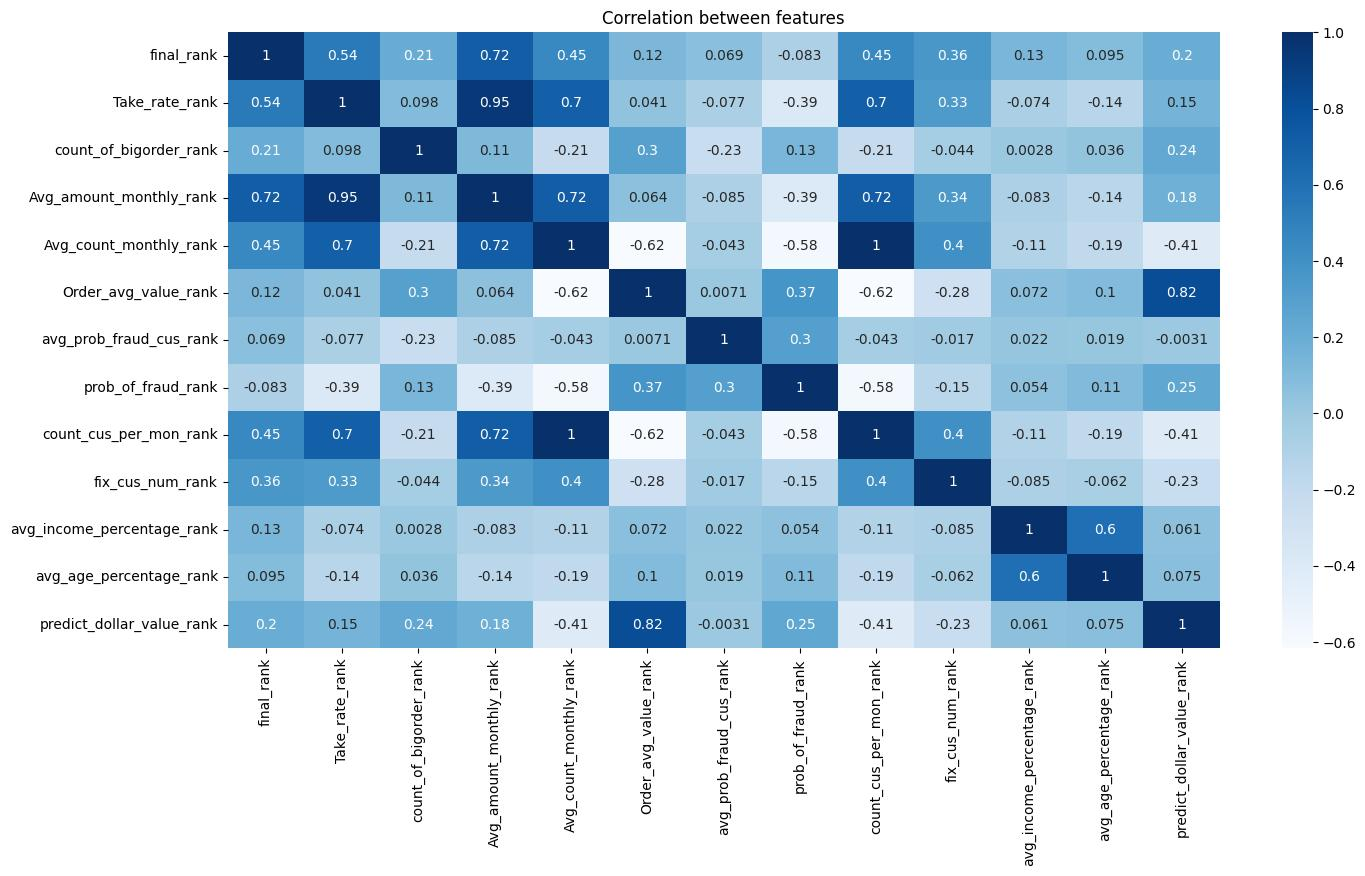

In [26]:
listOfImageNames = ['../plots/heatmap.jpg']
for imageName in listOfImageNames:
    display(Image(filename= imageName))

#### The line plot of the amount for the first 10 merchants and the last 10 merchants in the top 100 ranking table

By comparing the average amount monthly of the top_100 merchant's data of the top ten companies and the bottom ten companies, we can find that the amounts of the top ten companies are significantly higher than the amounts of the companies ranked 90-100 as a whole. And both of them have a large fluctuation. Therefore, the lower the ranking, the lower the overall amount will be, although there is no clear pattern of fluctuation of the amount value between adjacent rankings.

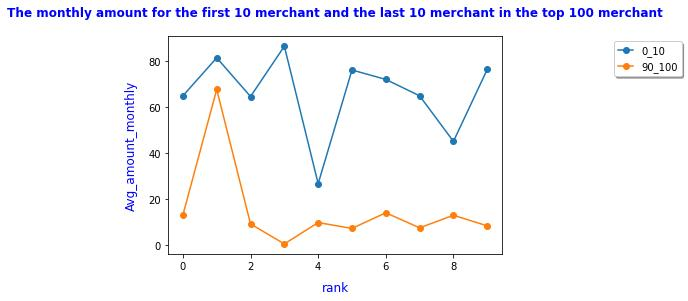

In [27]:
listOfImageNames = ['../plots/lineplot_amount_first10_last10.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

#### The line plot of the count for the first 10 merchants and the last 10 merchants in the top 100 ranking table

By comparing the average count monthly of the top ten companies and the last ten companies in the ranked top_100 table, we can find that the count of the top ten companies is significantly higher than the count of the companies ranked 91-100. And by observing the data, we can find that the average count monthly of the top ten companies has a decreasing trend as the ranking decreases, while the average count monthly of the companies ranked 91-100 has no big fluctuation and is close to the level. It can be seen that the lower the ranking, the more stable the value of count changes. At the same time, the value of count may have some influence on the rank of the company.

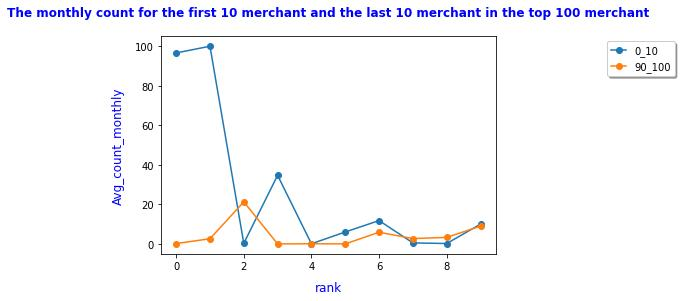

In [28]:
listOfImageNames = ['../plots/lineplot_count_first10_last10.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

#### The amount of the top 10 merchant amount in the ranking table of each sigements

By looking at the line graphs, we can see that the overall data is concentrated between 60 and 80, with only the values of health being more distributed below 60. The box plot on the right also shows that the average value of health is significantly lower than the average value of the other box plots. The average values in the box plots for sport and home are higher than the average values in the other box plots, so it is recommended to work with these two companies.


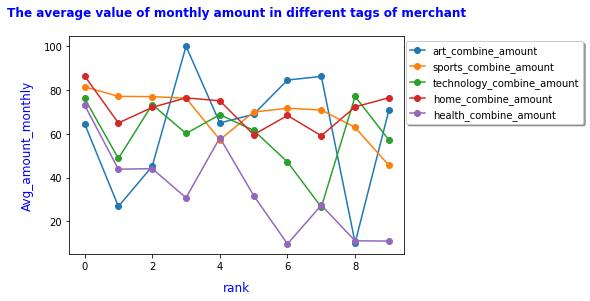

In [29]:
listOfImageNames = ['../plots/lineplot_amount_sigments.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

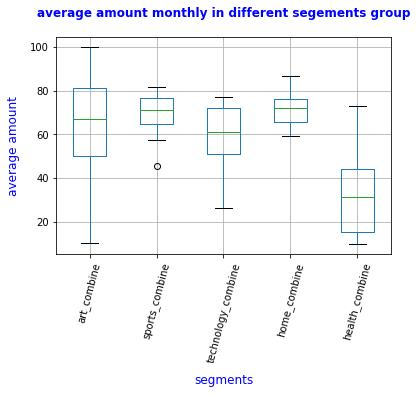

In [30]:
listOfImageNames = ['../plots/boxplot_amount_sigments.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

#### The count of the top 10 merchant count in the ranking table of each sigements

The line graph shows that the overall trend is downward from high to low, which proves that there is a certain relationship between count and rank. It can be found that the count of the data ranked first in the sport and home categories is higher, and in each group, there is a fluctuating peak, although the rank of the data where these peaks are located is not the same.

The box plot on the right shows that the average of the count values for home is higher than the other groups. Therefore it is more recommended to work with companies in the home category.

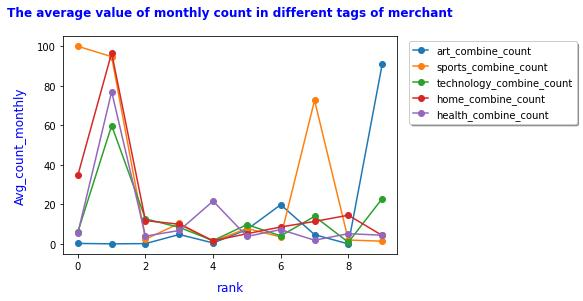

In [31]:
listOfImageNames = ['../plots/lineplot_count_sigments.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

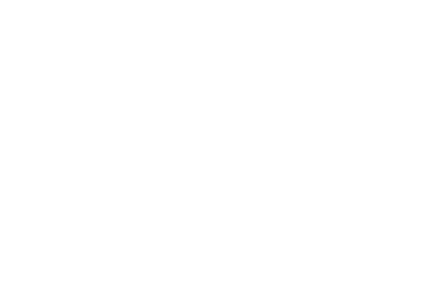

In [32]:
listOfImageNames = ['../plots/boxplot_count_sigments.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

#### The prob of 5 different segments in top 100 merchants among all merchants

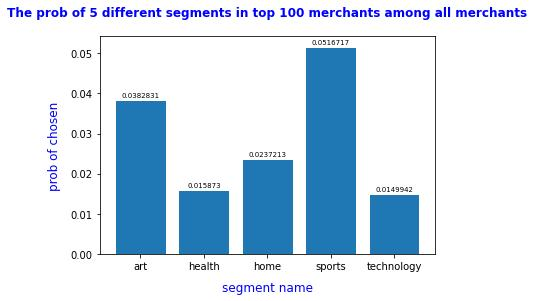

In [33]:
listOfImageNames = ['../plots/prob_sigments.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

#### The prob of different store type in top 100 merchants among all merchants

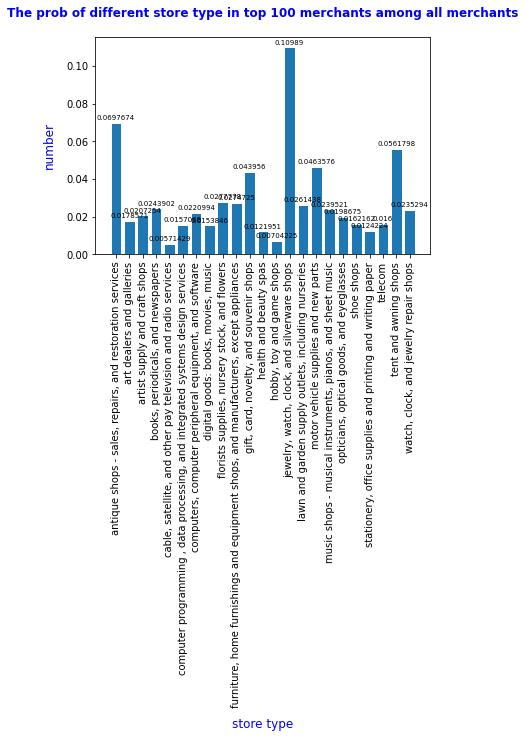

In [34]:
listOfImageNames = ['../plots/prob_stroe_type.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))

#### The number of different store type in top 100 merchants

By looking at the picture it can be seen that among the top 100 companies the number of tent companies is the highest, followed by companies in the gift cards category. It proves that the possibility of having a more efficient and effective cooperation with these companies is higher.

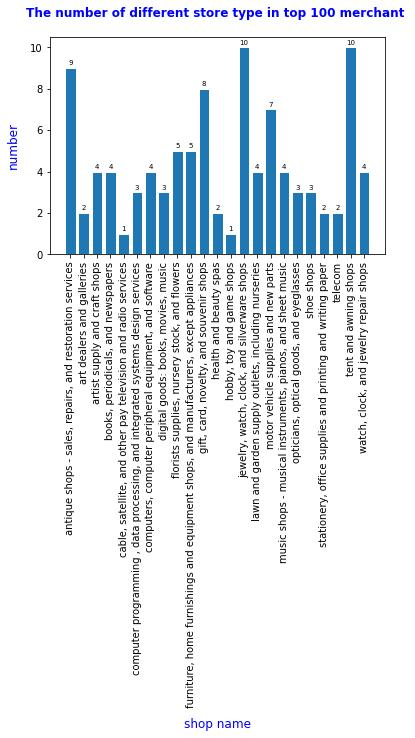

In [35]:
listOfImageNames = ['../plots/count_store_type.jpg']
for imageName in listOfImageNames:
    display(Image(filename = imageName))